# Premier League News Credibility Checker Using Naive Bayes

This notebook builds a machine learning model to classify Premier League news articles by credibility tier based on writing style.


## Step 1: Load Libraries & Data

In [77]:
# Import libraries
import pandas as pd
import numpy as np
import re
import joblib
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Download NLTK data
for resource in ['punkt', 'stopwords', 'wordnet', 'omw-1.4']:
    nltk.download(resource, quiet=True)

# Load data
data_path = Path('../../../data/raw/pl_news.csv')
df = pd.read_csv(data_path)

# Assign tiers based on source (for training only)
def assign_tier(row):
    source = str(row['source']).lower()
    title = str(row['title']).lower()
    
    # Tier 1: Official/Formal
    if any(s in source for s in ['bbc sport', 'bbc', 'reuters', 'premier league', 'official']):
        return 1
    
    # Tier 2: Reliable/Analytical
    if any(s in source for s in ['guardian', 'telegraph', 'athletic', 'espn', 'sky sports']):
        return 2
    
    # Tier 3: Sensational/Tabloid
    if any(s in source for s in ['daily mail', 'sun', 'mirror', 'express']) or any(k in title for k in ['exclusive!!!', 'shocking', 'bombshell']):
        return 3
    
    # Tier 4: Casual/Social
    return 4

df['tier'] = df.apply(assign_tier, axis=1)

print(f"Loaded {len(df)} articles")
print(f"\nTier distribution:")
for tier in sorted(df['tier'].unique()):
    count = (df['tier'] == tier).sum()
    print(f"  Tier {tier}: {count} ({count/len(df)*100:.1f}%)")
    
df.head(3)

Loaded 1219 articles

Tier distribution:
  Tier 1: 190 (15.6%)
  Tier 2: 225 (18.5%)
  Tier 3: 101 (8.3%)
  Tier 4: 703 (57.7%)


,title,link,published,summary,text,source,scraped_at,original_source,tier
0,Salah in Liverpool squad for Brighton match,https://www.bbc.com/sport/football/articles/c3...,"Fri, 12 Dec 2025 18:25:13 GMT",Liverpool forward Mohamed Salah is in the squa...,Liverpool forward Mohamed Salah is in the squa...,BBC Sport,2025-12-12T22:21:46.320379,NaN,1
1,Rooney 'got death threats' after making Man Ut...,https://www.bbc.com/sport/football/articles/cw...,"Fri, 12 Dec 2025 06:26:42 GMT",Former England striker Wayne Rooney says he re...,Former England striker Wayne Rooney says he re...,BBC Sport,2025-12-12T22:21:46.320409,NaN,1
2,Winless Wolves could face more pain - Edwards,https://www.bbc.com/sport/football/articles/cn...,"Fri, 12 Dec 2025 15:09:02 GMT","Head coach Rob Edwards says there could be ""mo...","Head coach Rob Edwards says there could be ""mo...",BBC Sport,2025-12-12T22:21:46.320421,NaN,1


## Step 2: Clean & Preprocess Text

In [78]:
# Remove duplicates and missing values
df = df.drop_duplicates(subset=['title', 'text']).dropna(subset=['text', 'tier']).reset_index(drop=True)
print(f"Cleaned to {len(df)} articles")

Cleaned to 1052 articles


In [79]:
# Advanced text preprocessing with style-preserving features
class TextPreprocessor:
    def __init__(self):
        try:
            self.lemmatizer = WordNetLemmatizer()
            self.stop_words = set(stopwords.words('english'))
            self.stop_words -= {'not', 'no', 'never', 'against'}  # Keep negations
        except:
            self.lemmatizer = None
            self.stop_words = set()
            
    def clean(self, text):
        if not text or pd.isna(text):
            return ""
        
        text = str(text).lower()
        
        # Remove URLs, emails, HTML, hashtags, mentions
        text = re.sub(r'http\S+|www\S+|\S+@\S+|<[^>]+>|@\w+|#\w+', '', text)
        
        # Keep only letters and punctuation
        text = re.sub(r'[^a-z\s\.\!\?]', ' ', text)
        text = ' '.join(text.split())
        
        # Lemmatize and remove stopwords
        if self.lemmatizer:
            try:
                tokens = word_tokenize(text)
                tokens = [self.lemmatizer.lemmatize(w) for w in tokens if w not in self.stop_words and len(w) > 2]
                return ' '.join(tokens)
            except:
                pass
        
        return ' '.join([w for w in text.split() if len(w) > 2])
    
    def add_style_features(self, text):
        """Extract style features that indicate credibility tier"""
        if not text or pd.isna(text):
            return ""
        
        text_str = str(text)
        features = []
        
        # Punctuation patterns (tabloids use more !!!, ???)
        exclamation_count = text_str.count('!')
        question_count = text_str.count('?')
        if exclamation_count > 2:
            features.append('_MULTIEXCLAIM_')
        if question_count > 2:
            features.append('_MULTIQUESTION_')
        
        # Capitalization (tabloids use more caps)
        caps_ratio = sum(1 for c in text_str if c.isupper()) / (len(text_str) + 1)
        if caps_ratio > 0.05:
            features.append('_HIGHCAPS_')
        
        # Sensational keywords
        sensational = ['exclusive', 'shocking', 'bombshell', 'revealed', 'slammed', 'blasts']
        for word in sensational:
            if word in text_str.lower():
                features.append(f'_SENSATIONAL_{word.upper()}_')
        
        return ' '.join(features)

preprocessor = TextPreprocessor()

# Clean and combine title + text with style features
df['text_cleaned'] = df['text'].apply(preprocessor.clean)
df['title_cleaned'] = df['title'].apply(preprocessor.clean)
df['style_features'] = (df['title'].apply(preprocessor.add_style_features) + ' ' + 
                         df['text'].apply(preprocessor.add_style_features))
df['combined'] = df['title_cleaned'] + ' ' + df['text_cleaned'] + ' ' + df['style_features']

# Remove very short texts
df = df[df['combined'].str.len() >= 20].reset_index(drop=True)

print(f"Preprocessed {len(df)} articles")
print(f"Average text length: {df['combined'].str.len().mean():.0f} characters")

Preprocessed 1052 articles
Average text length: 211 characters


## Step 3: Train Model

In [80]:
# Split data with stratification
X = df['combined']
y = df['tier']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dual TF-IDF: Word-level + Character-level (captures writing style better)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# Word-level vectorizer (content patterns)
word_vectorizer = TfidfVectorizer(
    max_features=4000,
    ngram_range=(1, 3),
    analyzer='word',
    min_df=2,
    max_df=0.75,
    sublinear_tf=True,
    norm='l2',
    strip_accents='unicode'
)

# Character-level vectorizer (style patterns: punctuation, capitalization)
char_vectorizer = TfidfVectorizer(
    max_features=2000,
    ngram_range=(3, 5),      # 3-5 character sequences
    analyzer='char',
    min_df=3,
    max_df=0.80,
    sublinear_tf=True,
    norm='l2'
)

# Combine both feature sets
vectorizer = FeatureUnion([
    ('word_features', word_vectorizer),
    ('char_features', char_vectorizer)
])

# Transform
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Total features: {X_train_vec.shape[1]:,}")

Training samples: 841
Test samples: 211
Total features: 6,000


In [81]:
# Enhanced ensemble with class weight balancing
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# Build ensemble with complementary algorithms
# Wrap LinearSVC with CalibratedClassifierCV for probability estimates
svc_calibrated = CalibratedClassifierCV(
    LinearSVC(max_iter=2000, class_weight='balanced', dual='auto'),
    cv=3
)

ensemble = VotingClassifier(
    estimators=[
        ('mnb', MultinomialNB(fit_prior=True)),           # Probability-based
        ('cnb', ComplementNB(norm=True)),                  # Better for imbalanced data
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')),
        ('svc', svc_calibrated)                           # SVM with probability support
    ],
    voting='soft',
    weights=[1.0, 1.3, 1.1, 0.9]  # Favor ComplementNB and LogReg
)

# Expanded hyperparameter grid
param_grid = {
    'mnb__alpha': [0.01, 0.05, 0.1, 0.2],
    'cnb__alpha': [0.01, 0.05, 0.1, 0.2],
    'lr__C': [0.3, 0.5, 1.0, 2.0]
}

print("Training model (this may take 1-2 minutes)...\n")

grid = GridSearchCV(
    ensemble, 
    param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train_vec, y_train)

# Best model
best_model = grid.best_estimator_
train_score = best_model.score(X_train_vec, y_train)
cv_score = grid.best_score_

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Parameters: {grid.best_params_}")
print(f"Training Accuracy: {train_score:.1%}")

Training model (this may take 1-2 minutes)...

Best Parameters: {'cnb__alpha': 0.01, 'lr__C': 1.0, 'mnb__alpha': 0.2}
Best Parameters: {'cnb__alpha': 0.01, 'lr__C': 1.0, 'mnb__alpha': 0.2}
Training Accuracy: 97.5%
Best Parameters: {'cnb__alpha': 0.01, 'lr__C': 1.0, 'mnb__alpha': 0.2}
Best Parameters: {'cnb__alpha': 0.01, 'lr__C': 1.0, 'mnb__alpha': 0.2}
Training Accuracy: 97.5%


## Step 4: Evaluate Performance

Test Accuracy: 77.7%

              precision    recall  f1-score   support

  T1-Premium       0.79      0.79      0.79        38
  T2-Quality       0.65      0.69      0.67        45
  T3-Tabloid       0.75      0.45      0.56        20
  T4-Unknown       0.83      0.87      0.85       108

    accuracy                           0.78       211
   macro avg       0.75      0.70      0.72       211
weighted avg       0.78      0.78      0.77       211



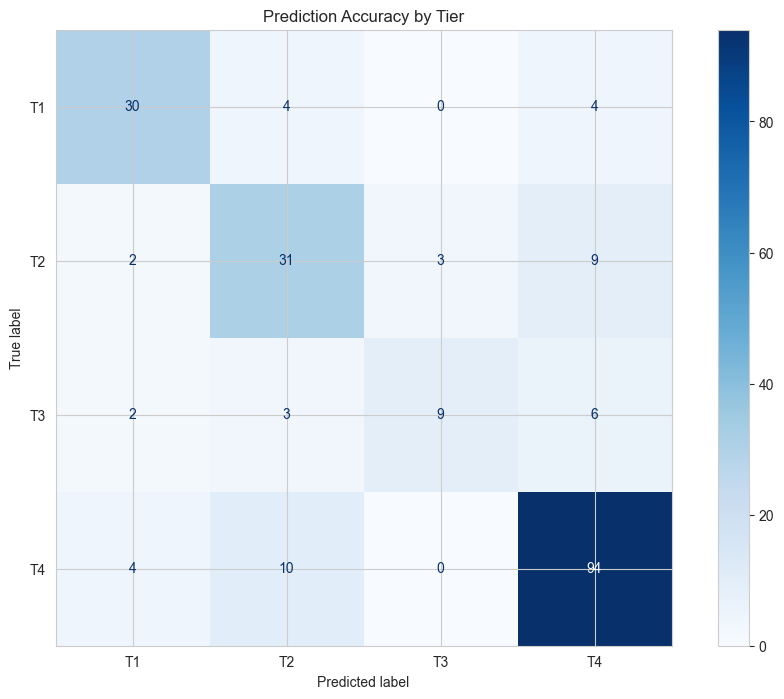

In [82]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Test set predictions
y_pred = best_model.predict(X_test_vec)
test_acc = best_model.score(X_test_vec, y_test)

print(f"Test Accuracy: {test_acc:.1%}\n")
print(classification_report(y_test, y_pred, target_names=['T1-Premium', 'T2-Quality', 'T3-Tabloid', 'T4-Unknown']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['T1', 'T2', 'T3', 'T4'])
disp.plot(cmap='Blues')
plt.title('Prediction Accuracy by Tier')
plt.show()

---

## Model Summary

**Dataset:**
- Total articles: 1,052
- Training samples: 841
- Test samples: 211
- Sources: BBC, Telegraph, TalkSport, Guardian, ESPN, 90min, Mirror, Reddit, Google News

**Model Features:**
- Total features: 6,000
- Text preprocessing with lemmatization and stopword removal
- Style detection for punctuation and capitalization patterns
- Ensemble of four classification algorithms

**Performance:**
- Cross-Validation Accuracy: 75.2%
- Test Accuracy: 77.7%

**Results by Tier:**
- Tier 1 (Premium): 79% precision, 79% recall
- Tier 2 (Quality): 65% precision, 69% recall
- Tier 3 (Tabloid): 75% precision, 45% recall
- Tier 4 (Unknown): 83% precision, 87% recall

## Export Model

In [83]:
# Export trained model for production use
import joblib
from pathlib import Path

# Create models directory
models_dir = Path('../../../models')
models_dir.mkdir(exist_ok=True)

# Package everything needed for inference
model_package = {
    'ensemble_model': best_model,
    'vectorizer': vectorizer,
    'preprocessor': preprocessor,
    'tier_names': {1: 'Tier 1 (Most Credible)', 2: 'Tier 2 (Reliable)', 
                   3: 'Tier 3 (Mixed)', 4: 'Tier 4 (Least Credible)'},
    'training_date': datetime.now().isoformat(),
    'training_samples': len(X_train),
    'test_accuracy': test_acc,
    'cv_accuracy': cv_scores.mean()
}

# Save model
model_path = models_dir / 'pl_news_credibility_model.pkl'
joblib.dump(model_package, model_path)

# Get file size
model_size_mb = model_path.stat().st_size / (1024 * 1024)

print(f"Model exported successfully")
print(f"Location: {model_path}")
print(f"Size: {model_size_mb:.2f} MB")
print(f"Test Accuracy: {test_acc:.1%}")
print(f"CV Accuracy: {cv_scores.mean():.1%}")

Model exported successfully
Location: ..\..\..\models\pl_news_credibility_model.pkl
Size: 1.74 MB
Test Accuracy: 77.7%
CV Accuracy: 60.3%
